In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px

In [2]:
data = pd.read_csv("G:\Загрузки\laptops.csv", encoding='latin-1')

In [3]:
data.head()

Unnamed: 0 Company      Product   TypeName  Inches  \
0           1   Apple  MacBook Pro  Ultrabook    13.3   
1           2   Apple  Macbook Air  Ultrabook    13.3   
2           3      HP       250 G6   Notebook    15.6   
3           4   Apple  MacBook Pro  Ultrabook    15.4   
4           5   Apple  MacBook Pro  Ultrabook    13.3   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Weight  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS  1.37kg   
1  128GB Flash Storage        Intel HD Graphics 6000  macOS  1.34kg   
2            256GB SSD         Intel HD Graphics 620  No OS  1.86kg   
3            512GB SSD            AMD Radeon Pro 455  macOS  1.83kg   
4            256GB SSD  Intel Iris Plus Graphics 650  macOS  1.37kg   

   Price_euros  
0      1339.69  
1       898.94  
2       575.00  
3      2537.45  
4      1803.60

#### Приведем датафрейм к виду, который можно анализировать:

In [4]:
data["Product"] = data["Product"].str.split("(").apply(lambda x: x[0])

data["Cpu_Speed"] = data["Cpu"].str.split(" ").apply(lambda x: x[-1]).str.replace("GHz", "")
data["Cpu_Vender"] = data["Cpu"].str.split(" ").apply(lambda x: x[0])
data["Cpu_Type"] = data["Cpu"].str.split(" ").apply(lambda x: x[1:4] if x[1] == "Celeron" and "Pentium" and "Xeon" else (x[1:3] if (x[1] == "Core" or x[0] == "AMD") else x[0]) )
data["Cpu_Type"] = data["Cpu_Type"].apply(lambda x: ' '.join(x))

split_mem = data['Memory'].str.split(' ', 1, expand=True)
data['Storage Type'] = split_mem[1]
data['Memory'] = split_mem[0]
data["Memory"].unique()
data["Ram"] = data["Ram"].str.replace("GB", "")
df_mem= data['Memory'].str.split('(\d+)',  expand=True)
data['Memory'] = pd.to_numeric(df_mem[1])
data.rename(columns={'Memory':'Memory (GB or TB)'}, inplace=True)
data['Memory (GB or TB)'] = data['Memory (GB or TB)'].apply(lambda x: 1024 if x==1 else x)
data['Memory (GB or TB)'] = data['Memory (GB or TB)'].apply(lambda x: 2048 if x==2 else x)
data.rename(columns={'Memory (GB or TB)':'Storage (GB)'}, inplace=True)

data["Weight"] = data["Weight"].str.replace("kg", "")
gpu_distribution_list = data["Gpu"].str.split(" ")
data["Gpu_Vender"] = data["Gpu"].str.split(" ").apply(lambda x: x[0])
data["Gpu_Type"] = data["Gpu"].str.split(" ").apply(lambda x: x[1:])
data["Gpu_Type"] = data["Gpu_Type"].apply(lambda x: ' '.join(x))
data['Touchscreen'] = data['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
data['Ips'] = data['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'

data['OpSys'] = data['OpSys'].apply(cat_os)
#меняем колонки местами, чтобы было красиво
data = data.reindex(columns=["Company", "TypeName", "Inches", "Touchscreen", "Ips", "Cpu_Vender", "Cpu_Type","Ram", "Storage (GB)", "Storage Type", "Gpu_Vender", "Gpu_Type", "Weight", "OpSys", "Price_euros" ])
#расставили все как нам удобно, теперь можно присвоить типы
data["Ram"] = data["Ram"].astype("int")
data["Storage (GB)"] = data["Storage (GB)"].astype("int")
data["Weight"] = data["Weight"].astype("float")
data.head()

Company   TypeName  Inches  Touchscreen  Ips Cpu_Vender Cpu_Type  Ram  \
0   Apple  Ultrabook    13.3            0    1      Intel  Core i5    8   
1   Apple  Ultrabook    13.3            0    0      Intel  Core i5    8   
2      HP   Notebook    15.6            0    0      Intel  Core i5    8   
3   Apple  Ultrabook    15.4            0    1      Intel  Core i7   16   
4   Apple  Ultrabook    13.3            0    1      Intel  Core i5    8   

   Storage (GB)   Storage Type Gpu_Vender                Gpu_Type  Weight  \
0           128            SSD      Intel  Iris Plus Graphics 640    1.37   
1           128  Flash Storage      Intel        HD Graphics 6000    1.34   
2           256            SSD      Intel         HD Graphics 620    1.86   
3           512            SSD        AMD          Radeon Pro 455    1.83   
4           256            SSD      Intel  Iris Plus Graphics 650    1.37   

                OpSys  Price_euros  
0                 Mac      1339.69  
1                 Mac       898.94  
2  Others/No OS/Linux       575.00  
3                 Mac      2537.45  
4                 Mac      1803.60

#### Посмотрим распределения числовых переменных:

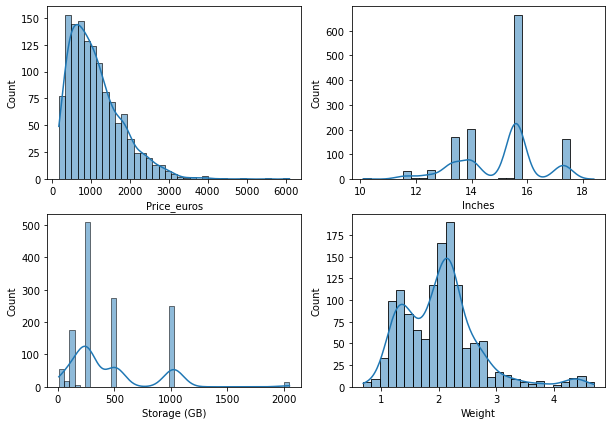

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
sns.histplot(data.Price_euros, kde = True,  ax=axes[0,0])
sns.histplot(data.Inches, kde = True,  ax=axes[0,1])
sns.histplot(data["Storage (GB)"], kde = True,  ax=axes[1,0])
sns.histplot(data.Weight, kde = True,  ax=axes[1,1])

plt.show()

Видим, что распределения не являются нормальными. Запросим их статистику (~~зачем?~~ так сказали)

In [6]:
print(data.Price_euros.describe() , data.Inches.describe(), data.Ram.describe(), data["Storage (GB)"].describe(), data.Weight.describe())

count    1303.000000
mean     1123.686992
std       699.009043
min       174.000000
25%       599.000000
50%       977.000000
75%      1487.880000
max      6099.000000
Name: Price_euros, dtype: float64 count    1303.000000
mean       15.017191
std         1.426304
min        10.100000
25%        14.000000
50%        15.600000
75%        15.600000
max        18.400000
Name: Inches, dtype: float64 count    1303.000000
mean        8.382195
std         5.084665
min         2.000000
25%         4.000000
50%         8.000000
75%         8.000000
max        64.000000
Name: Ram, dtype: float64 count    1303.000000
mean      447.809670
std       366.037159
min         8.000000
25%       256.000000
50%       256.000000
75%       512.000000
max      2048.000000
Name: Storage (GB), dtype: float64 count    1303.000000
mean        2.038734
std         0.665475
min         0.690000
25%         1.500000
50%         2.040000
75%         2.300000
max         4.700000
Name: Weight, dtype: float64


Максимальная цена ноутбука - 6099 евро, а минимальная - 174.  
Средняя ~~температура по больнице~~ диагональ - 15 дюймов  
Максимальный вес - 4,7 кг. Минимальный - 700 грамм

#### Перейдем к основному анализу

Посмотрим сколько ноутбуков у каждой компании:

<AxesSubplot:>

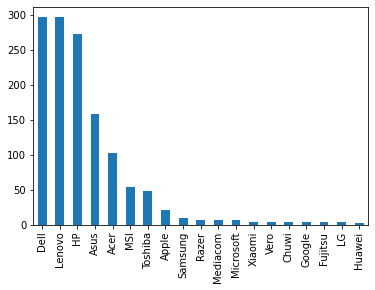

In [7]:
data["Company"].value_counts().plot(kind="bar")

Видим, что больше всех моделей ноутбуков производят Делл и Леново

А теперь посмотрим, что там по ценам:

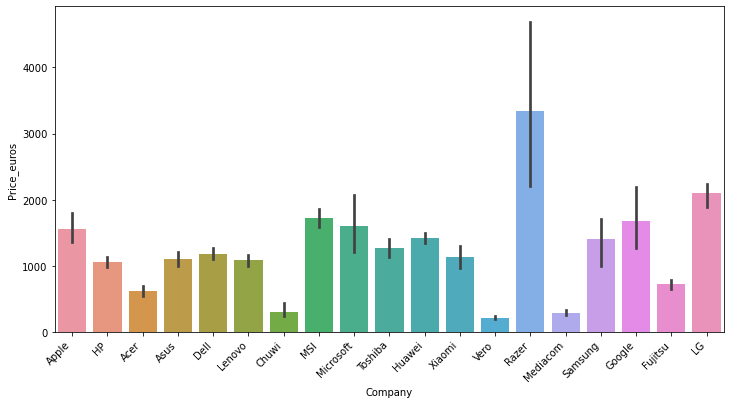

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=data, x=data['Company'], y = data["Price_euros"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Видим, что у Razer(специализируются на игровых ноутбуках) цены самые высокие. А еще видим, что можно сравнить цены у Asus & Lenovo, Chuwi & Mediacom, Acer & Fujitsu, Apple & Microsoft:

In [9]:
print(data[data.Company == "Asus"].Price_euros.mean(), data[data.Company == "Lenovo"].Price_euros.mean(), data[data.Company == "HP"].Price_euros.mean())
print(data[data.Company == "Chuwi"].Price_euros.mean(), data[data.Company == "Mediacom"].Price_euros.mean())
print(data[data.Company == "Acer"].Price_euros.mean(), data[data.Company == "Fujitsu"].Price_euros.mean())
print(data[data.Company == "Apple"].Price_euros.mean(), data[data.Company == "Microsoft"].Price_euros.mean())

1104.1693670886075 1086.3844444444444 1067.774854014598
314.2966666666667 295.0
626.7758252427185 729.0
1564.1985714285713 1612.3083333333334


Делаем вывод, что сравнивать их бесполезно, но на всякий случай проведем тест Манна Уитни.
Для этого нам надо проверить нормальность распределения цен от производителя: 

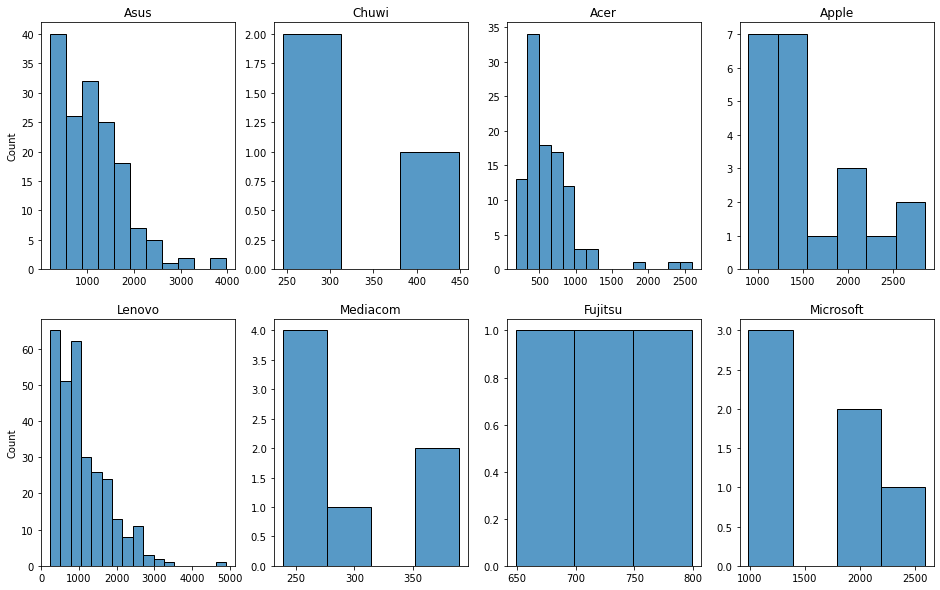

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))


sns.histplot(x=data[data.Company == 'Asus'].Price_euros,    ax=axes[0,0])
axes[0,0].set(title='Asus', xlabel ='')

sns.histplot(x=data[data.Company == 'Lenovo'].Price_euros,    ax=axes[1,0])
axes[1,0].set(title='Lenovo', xlabel ='')

sns.histplot(x=data[data.Company == 'Chuwi'].Price_euros,    ax=axes[0,1])
axes[0,1].set(title='Chuwi', xlabel ='', ylabel = '')

sns.histplot(x=data[data.Company == 'Mediacom'].Price_euros,    ax=axes[1,1])
axes[1,1].set(title='Mediacom', xlabel ='', ylabel = '')

sns.histplot(x=data[data.Company == 'Acer'].Price_euros,    ax=axes[0,2])
axes[0,2].set(title='Acer', xlabel ='', ylabel = '')

sns.histplot(x=data[data.Company == 'Fujitsu'].Price_euros,    ax=axes[1,2])
axes[1,2].set(title='Fujitsu', xlabel ='', ylabel = '')

sns.histplot(x=data[data.Company == 'Apple'].Price_euros,    ax=axes[0,3])
axes[0,3].set(title='Apple', xlabel ='', ylabel = '')

sns.histplot(x=data[data.Company == 'Microsoft'].Price_euros,    ax=axes[1,3])
axes[1,3].set(title='Microsoft', xlabel ='', ylabel = '')

plt.show()

Видим, что нормальных распределений нет... и используем критерий Манна-Уитни (количественная переменная, распределение, отличное от нормального, независимые выборки):

In [11]:
print(scipy.stats.mannwhitneyu(data[data.Company == "Asus"].Price_euros, data[data.Company == "Lenovo"].Price_euros),
scipy.stats.mannwhitneyu(data[data.Company == "Chuwi"].Price_euros, data[data.Company == "Mediacom"].Price_euros),
scipy.stats.mannwhitneyu(data[data.Company == "Acer"].Price_euros, data[data.Company == "Fujitsu"].Price_euros),
scipy.stats.mannwhitneyu(data[data.Company == "Microsoft"].Price_euros, data[data.Company == "Apple"].Price_euros))

MannwhitneyuResult(statistic=23871.5, pvalue=0.7599544231347888) MannwhitneyuResult(statistic=9.0, pvalue=0.8333333333333333) MannwhitneyuResult(statistic=91.5, pvalue=0.2337544121131241) MannwhitneyuResult(statistic=65.0, pvalue=0.9321374277896018)


Видим, что p-value сильно больше 0.05, поэтому цены статистически различаются.  
Попробуем найти ноутбуки с одинаковыми характеристиками (диагональ, процессор, видеокарта, память) и посмотреть на их цены:

In [12]:
xxx = data
xxx = xxx[data["Inches"].isin(data["Inches"].mode()) ]
xxx = xxx[data["Cpu_Type"].isin(data["Cpu_Type"].mode()) ]
xxx = xxx[data["Gpu_Type"].isin(data["Gpu_Type"].mode()) ]
xxx = xxx[data["Storage (GB)"].isin(data["Storage (GB)"].mode()) ]
xxx

C:\Users\mitro\AppData\Local\Temp/ipykernel_19812/2235843488.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xxx = xxx[data["Cpu_Type"].isin(data["Cpu_Type"].mode()) ]
C:\Users\mitro\AppData\Local\Temp/ipykernel_19812/2235843488.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xxx = xxx[data["Gpu_Type"].isin(data["Gpu_Type"].mode()) ]
C:\Users\mitro\AppData\Local\Temp/ipykernel_19812/2235843488.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xxx = xxx[data["Storage (GB)"].isin(data["Storage (GB)"].mode()) ]


Company   TypeName  Inches  Touchscreen  Ips Cpu_Vender Cpu_Type  Ram  \
24         HP  Ultrabook    15.6            0    0      Intel  Core i7    8   
351        HP   Notebook    15.6            0    0      Intel  Core i7    8   
506      Asus   Notebook    15.6            0    0      Intel  Core i7    8   
600        HP   Notebook    15.6            0    0      Intel  Core i7    8   
754      Asus   Notebook    15.6            0    0      Intel  Core i7    4   
872   Toshiba   Notebook    15.6            0    1      Intel  Core i7    8   
1060       HP   Notebook    15.6            0    0      Intel  Core i7    8   
1133       HP  Ultrabook    15.6            0    0      Intel  Core i7    8   

      Storage (GB)    Storage Type Gpu_Vender         Gpu_Type  Weight  \
24             256             SSD      Intel  HD Graphics 620    1.91   
351            256             SSD      Intel  HD Graphics 620    1.84   
506            256  SSD +  1TB HDD      Intel  HD Graphics 620    2.00   
600            256             SSD      Intel  HD Graphics 620    1.84   
754            256             SSD      Intel  HD Graphics 620    2.37   
872            256             SSD      Intel  HD Graphics 620    2.00   
1060           256             SSD      Intel  HD Graphics 620    2.04   
1133           256             SSD      Intel  HD Graphics 620    1.84   

        OpSys  Price_euros  
24    Windows        659.0  
351   Windows       1304.0  
506   Windows       1224.0  
600   Windows       1219.0  
754   Windows        849.9  
872   Windows       1388.0  
1060  Windows       1070.0  
1133  Windows        752.0

Мне просто было интересно. Выводов нет(их 8 штук, цена разная от 659 евро до 1388(то есть на цену помимо конфигурации влияет что-то еще), производит в основном HP), но зато есть "isin"...

Посмотрели на цены по компаниями, теперь давайте посмотрим на цены в зависимости от типов ноутбуков:

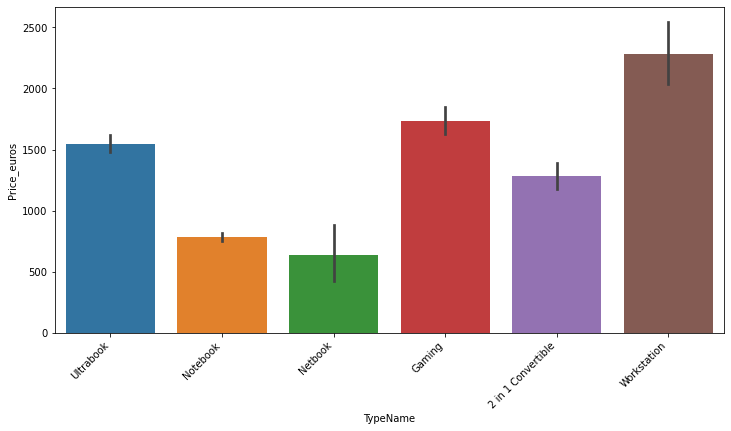

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=data, x=data['TypeName'], y = data["Price_euros"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

По графику видно, что цены статистически различаются. 


Давайте посмотрим на количество моделей портативных компьютеров:

<AxesSubplot:ylabel='TypeName'>

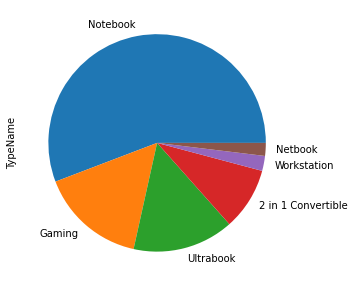

In [14]:
ax = plt.figure(figsize=(6, 5))
ax.set_facecolor("white")
data["TypeName"].value_counts().plot(kind="pie")


Видим, что ноутбуков больше половины. А нетбуков - меньше всего. Довольно много игровых и ультрабуков, чуть меньше - 2 в 1. Заметим, что самая большая средняя цена и самая маленькая средняя цена у нетбуков и рабочих станций, у которых на диаграмме самые маленькие сектора.  

### Пришло время строить тепловую карту! 

<AxesSubplot:>

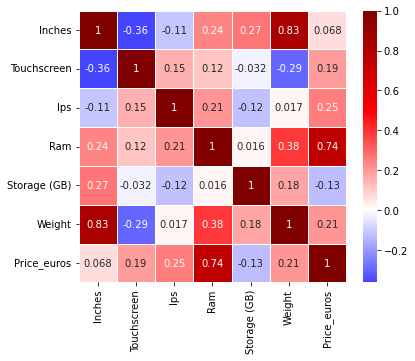

In [15]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr(), cmap="seismic", center=0, linewidths=.5, annot=True)

Видно, что на цену влияет оперативка, а еще вес коррелирует с дюймами

С другой стороны видно, что диагональ вообще никак от наличия сенсора не зависит. И вес с сенсором тоже не коррелируют. 

Сначала рассмотрим корреляцию цены и оперативки (по методичке хабра):  
- Еще  раз посмотрим на распределение цен ноутбуков:

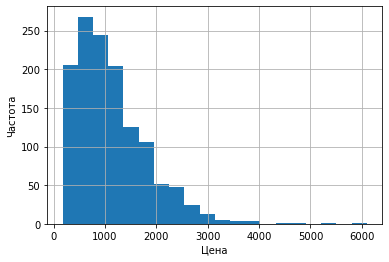

In [16]:
df = data
#уже не seaborn, разные библиотеки используем и всё такое...
df.Price_euros.hist(bins=20)
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

Попытаемся сделать его нормальным...

In [17]:
dff = df
dff["Price_euros"].apply(np.log).hist(bins = 20)
plt.show()

Построим график зависимости оперативки от нормально распределенной цены:

In [18]:
xs = dff['Ram']
ys = dff['Price_euros'].apply(np.log)

pd.DataFrame(np.array([xs,ys]).T).plot.scatter(0, 1, s=12, grid=True)
plt.show()

Считаем коэффициент корреляции и p-value:

(Пирсон выбран, потому что обе переменные измерены в количественной шкале и приведены к нормальному распределению.)

In [19]:
#приведенная к нормальному распределению цена
corr, p_val = scipy.stats.pearsonr(xs, ys)
print(corr, p_val)

#исходные данные
corr, p_val = scipy.stats.pearsonr(data.Price_euros, data.Ram)
print(corr, p_val)

0.6848033256149075 5.086106180730484e-181
0.7430071352507002 3.910343561935158e-229


Видим, что если приводить распределение к нормальному, то коэффициент корелляции меняется (0.74 -> 0.68). Посчитали p-value - сильно меньше 0.05 => кореллируют. 

Вес неприводим к нормальному распределению, поэтому Спирман:

In [20]:
corr, p_val = scipy.stats.spearmanr(data.Weight, data.Inches)
print(corr, p_val)

0.8792565261312657 0.0


Зависит)))  
(вес коррелирует с диагональю)

### А теперь пришло время категориальных переменных! 

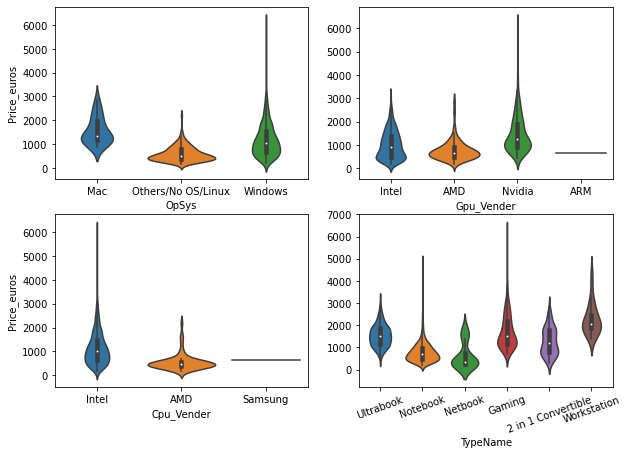

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
sns.violinplot(x="TypeName", y="Price_euros", data = data,  ax=axes[1,1])
sns.violinplot(x="Gpu_Vender", y="Price_euros", data = data,  ax=axes[0,1])
sns.violinplot(x="Cpu_Vender", y="Price_euros", data = data,  ax=axes[1,0])
sns.violinplot(x="OpSys", y="Price_euros", data = data,  ax=axes[0,0])
axes[1,1].tick_params(axis='x', labelrotation = 20)
axes[0,1].set(ylabel='')
axes[1,1].set(ylabel='')
plt.show()

Заметно, что процессор "самсунг" у одного ноутбука, также как и видеокарта "ARM". Проверим:

In [22]:
data[data['Cpu_Vender'] == 'Samsung']

Company            TypeName  Inches  Touchscreen  Ips Cpu_Vender  \
1191  Samsung  2 in 1 Convertible    12.3            1    1    Samsung   

           Cpu_Type  Ram  Storage (GB)   Storage Type Gpu_Vender  \
1191  S a m s u n g    4            32  Flash Storage        ARM   

           Gpu_Type  Weight               OpSys  Price_euros  
1191  Mali T860 MP4    1.15  Others/No OS/Linux        659.0

In [23]:
data[data['Gpu_Vender'] == 'ARM']

Company            TypeName  Inches  Touchscreen  Ips Cpu_Vender  \
1191  Samsung  2 in 1 Convertible    12.3            1    1    Samsung   

           Cpu_Type  Ram  Storage (GB)   Storage Type Gpu_Vender  \
1191  S a m s u n g    4            32  Flash Storage        ARM   

           Gpu_Type  Weight               OpSys  Price_euros  
1191  Mali T860 MP4    1.15  Others/No OS/Linux        659.0

Опа, это один и тот же ноутбук...

Такое чувство, что много нормальных распределений.  
По графику "Op_Sys" видно, что мак и виндоус дороже других операционных систем. Самый дорогой ноутбук из представленных, на виндоусе. (~~кто в здравом уме покупает ноут за 6000 евро~~).  Большинство пк на маке дороже большинства пк на виндоусе.   
По графику Cpu и Gpu видно, что у AMD все цены примерно одинаковы. Nvidia (у Gpu) дороже всех остальных. Процессоры Intel дороже AMD и samsung.  
По графику "TypeName" видно, что нетбуки дешевле всех остальных (удивительно). А игровые - дороже всех остальных (удивительно!). В среднем, цена рабочей станции (workstation) выше всех остальных средних цен пк. А еще видим, что есть много нетбуков за 500 евро и чуть меньшее количество, но все еще достаточное, за 1500 евро.(что, кстати, подтверждается барплотом(ячейка 13))  
Самое нормальное распределение у ультрабуков.   

### Цена и всё, что на неё влияет

In [24]:
model_pr = smf.ols('Price_euros ~ (C(Ram)+C(Touchscreen)+C(Inches)+C(Company)+C(TypeName)+C(Weight)+C(Gpu_Vender)+C(Ips))', data=data).fit()

table = sm.stats.anova_lm(model_pr, typ=2)

print(table)

                      sum_sq      df          F         PR(>F)
C(Ram)          5.974334e+07     8.0  87.440240  9.625255e-112
C(Touchscreen)  5.457855e+04     1.0   0.639049   4.242305e-01
C(Inches)       9.763110e+06    17.0   6.724362   1.545789e-15
C(Company)      1.089531e+07    18.0   7.087269   2.193956e-17
C(TypeName)     1.876159e+07     5.0  43.935090   2.428395e-41
C(Weight)       7.038509e+07   170.0   4.847788   1.618719e-58
C(Gpu_Vender)   3.472740e+06     3.0  13.553854   1.099053e-08
C(Ips)          4.989847e+05     1.0   5.842505   1.580763e-02
Residual        9.266547e+07  1085.0        NaN            NaN


In [25]:
model = smf.ols('Price_euros ~ C(Ram)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df           F         PR(>F)
C(Ram)    3.756242e+08     8.0  233.187705  1.385992e-244
Residual  2.605507e+08  1294.0         NaN            NaN

1. Цена зависит от оперативки (подтвердили, ура!)
2. Вообще тут надо где-то использовать Крускала-Уоллиса и делать какие-то поправки на множественные сравнения(у меня такое чувство, что это поправка Бонферони. Но нет, потому что она снижает появление ложноположительных результатов, а у нас тут очень четко ничего на цену не влияет). Ну даже по тепловой карте, в принципе, очевидно, что во всем виновата оперативка. 

Давайте на всякий случай посмотрим как влияют на цену оперативка и IPS(второе место на тепловой карте):

In [26]:
model_pr1 = smf.ols('Price_euros ~ (C(Ram):C(Ips))', data=data).fit()
table1 = sm.stats.anova_lm(model_pr1, typ=2)
print(table1)

                     sum_sq      df         F    PR(>F)
C(Ram):C(Ips)  9.816439e+04    17.0  0.029606  0.970829
Residual       2.510164e+08  1287.0       NaN       NaN


C:\Users\mitro\anaconda3\envs\an\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 2
  warnings.warn('covariance of constraints does not have full '


Ну, никак. Критерий Фишера маленький, PR - большой.

### Финальный график... всё от всего...

In [27]:
fig = px.scatter(data_frame=data,
                 x="Company",
                 y="Price_euros", 
                 color="TypeName",
                 size='Weight',
                 
                 hover_data=['Ram', "Touchscreen", "Ips", "Storage (GB)", "Cpu_Type"])
fig.show()

Красиво, правда?  
Видно, что у Razer и вправду в осномном игровые ноутбуки. А основную массу рабочих станций производит hp. А еще видно, что у эппла не очень тяжелые ультрабуки, впрочем, как и у майкрософта. MSI производит игровые ноутбуки до 3000 евро. У asus, dell и lenovo много всего разного. А у huawei ~~который пытается вписаться к эпплу и майкрософт в тусовку~~ всего 2 легких ультрабука. Vero, Chuwi, mediacom - дешевые игровые ноутбуки (до 500 евро), Fujitsu - чуть подороже (до 1000 евро). Cамый тяжелый ноутбук производит компания Dell, он игровой и стоит дороже 3000 евро. Рабочие станции делают Dell, HP и lenovo. Самый дешевый - нетбук от Acer, самый дорогой - игровой от Razer.  Все остальное можно посмотреть, наведя мышку на кружок. 

### Итоговые выводы

1.  В представленном датасете больше всего моделей ноутбуков у Lenovo, Dell и HP.  
2.  Самые дорогие пк у Razer, самые дешевые у Vero.  
3.  Самый дорогий тип пк - игровой, самый дешевый - нетбук.  
4.  Самый популярный (лидирующий) тип портативного компьютера - ноутбук, самый непопулярный - нетбук.   
5.  Наиболее влияющим на цену фактором является оперативная память.   
6.  Между собой статистически значимо коррелирует вес и диагональ пк.  
~~1.  Самсунг не занимается процессорами, а видеокарты от ARM - это миф.~~  
7. Не смотря на то, что ноутбуки популярнее всех остальных пк, не все компании занимаются их производством. А вот нетбуки производят довольно много(Asus, Acer, HP, Lenovo, Samsung). 